In [1]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
table = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
sp500_list = table[0]['Symbol'].to_list()
sp500_list = [s.replace('.', '-') for s in sp500_list]
len(sp500_list)

503

In [3]:
table = pd.read_html('https://en.wikipedia.org/wiki/Nasdaq-100')
nasdaq_list = table[4]['Ticker'].to_list()
nasdaq_list = [s.replace('.', '-') for s in nasdaq_list]
len(nasdaq_list)

102

In [4]:
stock_pool = list(set(sp500_list).union(set(nasdaq_list)))
stock_pool = np.random.choice(stock_pool, 50, replace=False)

In [5]:
from main import stocks_norm_return
norm_return = stocks_norm_return(stock_pool, '2022-01-01', '2022-10-31', dropna=True)

[*********************100%***********************]  50 of 50 completed


In [6]:
spy = yf.download("SPY", start='2022-01-01', end='2022-10-31')

[*********************100%***********************]  1 of 1 completed


In [11]:
from main import MC_portfolio

p = MC_portfolio(norm_return, 1e6)
p.mc_stock_choice(iter=1000, k=10, history=True)
print(p.best_sharpe)
p.mc_weight_choice(p.best_stocks)
print(p.best_sharpe)

0.48240193143651583
1.05426137571104


In [12]:
print(p.best_stocks)
print(p.best_weights)

['CPB' 'ADSK' 'CDW' 'CSGP' 'LYB' 'WAB' 'SYK' 'K' 'DVN' 'PSX']
[0.15839275 0.03395025 0.01642959 0.09309017 0.04957975 0.03832777
 0.03709042 0.18027696 0.26910136 0.12376097]


In [13]:
hist = np.array(p.all_stocks)
best_10 = hist[np.argsort(p.all_sharpe)][-10:]

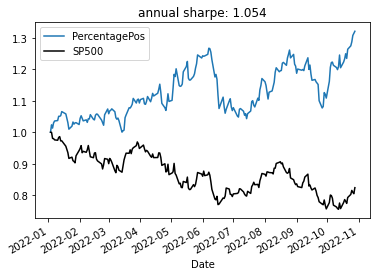

In [14]:
from main import build_portfolio, init_weight_choice

portfolio = build_portfolio(norm_return, 1e6, p.best_stocks, p.best_weights)
# for i in np.random.choice(np.arange(len(hist)), 10, replace=False):
#     portfolio = build_portfolio(norm_return, 1e6, hist[i], init_weight_choice(len(hist[i])))
portfolio.PercentagePos.plot()
(spy['Adj Close'] / spy['Adj Close'].iloc[0]).plot(c='black', label='SP500')
plt.legend()
plt.title(f'annual sharpe: {p.best_sharpe:.3f}')
plt.show()

In [ ]:
portfolio.DailyPercentageReturn.mean()

0.0019002328607892309